# Berendsen Thermostat

The Berendsen Thermostat (BT) uses a tapered velocity scaling approach. In a strict velocity scaling approach
the temperature $T_e$ is estimated, through a quantity proportional to $\langle v^2 \rangle$,
and the velocities are scaled to values consistent with the desired temperature :math:`T_d`,
as in :math:`v_i \to \alpha v_i`. Being completely inconsistent with physical laws,
it is preferable to use the same simple algorithm but more gently so that the dynamics during the thermostat period is
more consistent with the underlying equations of motion.
In the BT we begin with an model for the temperature as we would like to see it evolve over a slower
timescale :math:`\tau_{B}`. One model is

.. math::
   \frac{dT}{dt} = \frac{T_d - T}{\tau_{B}},

This equation can be solved analytically to yield

.. math::
   T(t) = T(0)e^{-t/\tau_B} + \left(1 - e^{-t/\tau_B}  \right)T_d ,

which can be seen to transition from the initial temperature :math:`T(0)` to the desired temperature :math:`T_d`
on a time scale of :math:`\tau_{B}`. By choosing :math:`\tau_{B}` to be many time steps we can eventually equilibrate
the system while allowing it to explore configurations closer to the real (not velocity scaled) dynamics.

To implement BT we discretize the BT model across one time step to obtain

.. math::
   T(t + \Delta t) = T(t) + \frac{\Delta t}{\tau_B}\left(T_d - T(t) \right) .

We want to scale the current velocities such that this new temperature :math:`T(t+\Delta t)` is achieved,
because that the temperature prescribed by the BT.
Finding the ratio then of the target temperature and the current temperature, we get

.. math::
   \frac{T(t + \Delta t)}{T(t) } = 1+ \frac{\Delta t}{\tau_{B}}\left(\frac{T_d}{T(t) } - 1 \right)

Taking the square root this yields the scaling factor for the velocities.

The BT is implemented in Sarkas with several epochs. You can specify the number of epochs and the individual
strengths :math:`\tau_{B,j}` (What is this ?). This allows for a stronger thermostat initially,
but tapering to a more gentle thermostat toward the end of the equilibration phase.

Below ww show a plot of the temperature difference

.. math::

    \Delta T(t) = T(t) - T_d

for several values of :math:`\tau_B`. As you can see the smaller :math:`\tau_B` the faster :math:`T(t)` reaches the
desired temperature.

In [1]:
# Import the usual libraries
%pylab
%matplotlib inline
import os
plt.style.use('MSUstyle')
# Import sarkas
from sarkas.processes import Simulation, PostProcess, PreProcess

# Create the file path to the YAML input file
example_directory = os.path.join('..',
                                 os.path.join('sarkas',
                                              os.path.join('examples', 'Berendsen')))

input_file_name = os.path.join(example_directory, 'yocp_cgs_pp_therm.yaml' )



Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
# preproc = PreProcess(input_file_name)
# preproc.setup(read_yaml=True)
# preproc.run()

In [3]:
taus = np.array([ 1.0, 2.0, 5.0, 10., 50., 100. ])

for i, tau in enumerate(taus):
    args = {
        'Thermostat': {'berendsen_tau': tau}, # Change tau for each simulation
            
            "IO":   # Store all simulations' data in simulations_dir,
                # but save the dumps in different subfolders (job_dir)
            {
                "simulations_dir": 'Berendsen_Taus',
                "job_dir": "tau_{}".format(int(tau) ),
                "verbose": False # This is so not to print to screen for every run
            },
    }
    # Run the simulation.
    sim = Simulation(input_file_name)
    sim.setup(read_yaml=True, other_inputs=args)
    sim.run()
    
    print('Tau = {} Done'.format(tau))

Tau = 1.0 Done
Tau = 2.0 Done
Tau = 5.0 Done
Tau = 10.0 Done
Tau = 50.0 Done
Tau = 100.0 Done


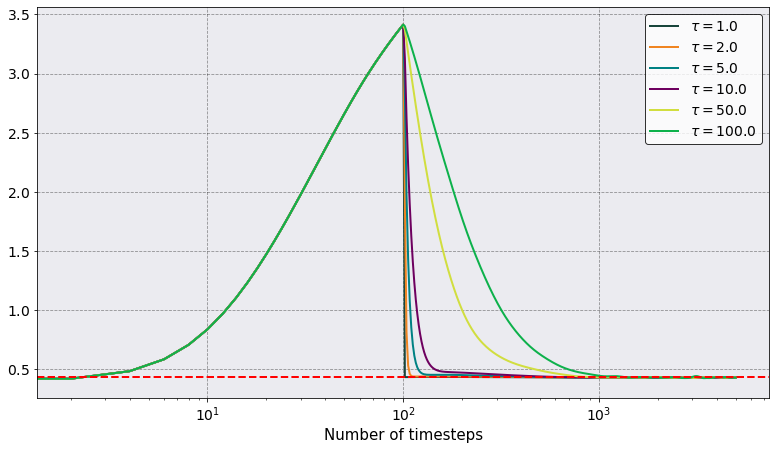

In [31]:
fig, axt = plt.subplots(1,1, figsize = (12,9))

for i, tau in enumerate(taus):
    args = {
        'Thermostat': {'berendsen_tau': tau}, # Change tau for each simulation
            
            "IO":   # Store all simulations' data in simulations_dir,
                # but save the dumps in different subfolders (job_dir)
            {
                "simulations_dir": 'Berendsen_Taus',
                "job_dir": "tau_{}".format(int(tau) ),
                "verbose": False # This is so not to print to screen for every run
            },
    }

    postproc = PostProcess(input_file_name)
    postproc.setup(read_yaml=True, other_inputs = args)
    postproc.therm.setup(postproc.parameters, phase = 'equilibration')
    postproc.therm.parse()
    
    postproc.therm.plot(
        scaling = (postproc.therm.dt, postproc.parameters.eV2K),   
        y = 'Temperature', 
        xlabel = 'Number of timesteps', logx = True, ax = axt)

axt.legend([
    r'$\tau = 1.0$', 
    r'$\tau = 2.0$',
    r'$\tau = 5.0$',
    r'$\tau = 10.0$',
    r'$\tau = 50.0$',
    r'$\tau = 100.0$'])
axt.axhline(postproc.thermostat.temperatures_eV[0], ls = '--', color = 'r', label = 'Desired $T$')
# fig.tight_layout()